In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

from sklearn.linear_model import LinearRegression

sns.set_theme(style='whitegrid', palette='pastel', font_scale=1.1)

data = pd.read_csv('train.csv')
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
#Dataset information
print("Shape:", data.shape)

data.info()

Shape: (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int

In [3]:
#Check for missing values
missing = data.isnull().sum().sort_values(ascending=True)
missing[missing > 0]

Electrical         1
MasVnrArea         8
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
BsmtFinType2      38
BsmtExposure      38
GarageQual        81
GarageYrBlt       81
GarageFinish      81
GarageType        81
GarageCond        81
LotFrontage      259
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

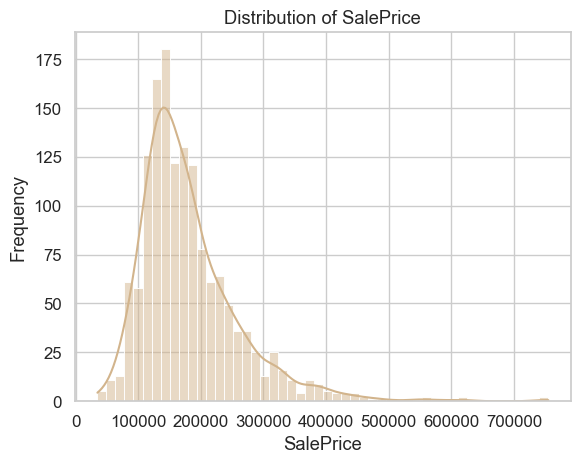

In [4]:
#Distribution
sns.histplot(data["SalePrice"], bins=50, kde=True, color="tan")
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

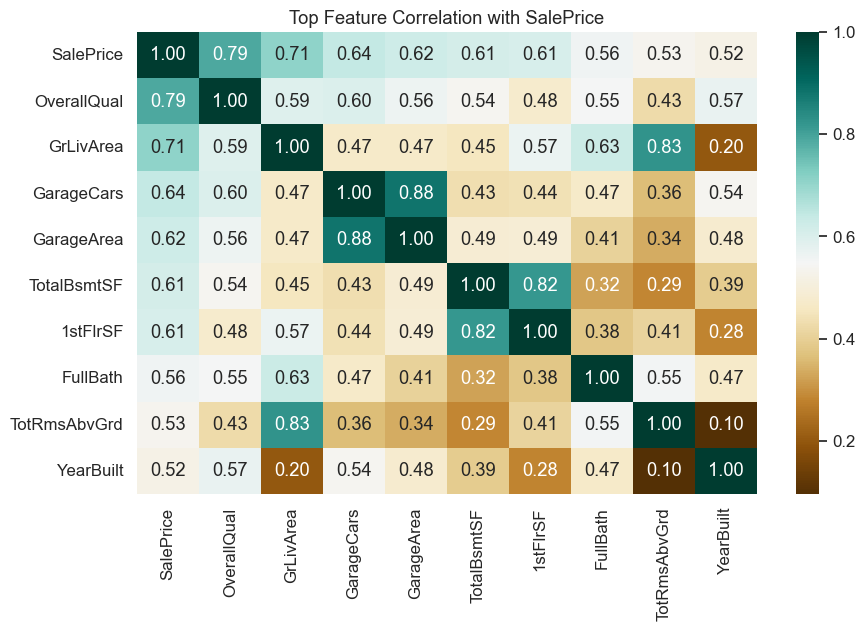

In [5]:
#Correlation heatmap for the top features
numeric_features = data.select_dtypes(include=['int64', 'float64'])

corr = numeric_features.corr()

#top 10 features correlated with SalePrice
top_features_corr = corr['SalePrice'].abs().sort_values(ascending=False).head(10).index

#plot visual
plt.figure(figsize=(10,6))
sns.heatmap(numeric_features[top_features_corr].corr(), annot=True, cmap='BrBG', fmt='0.2f')
plt.title('Top Feature Correlation with SalePrice')
plt.show()

In [6]:
#Data Preprocessing

#split features and target
X = data.drop(['Id', 'SalePrice'], axis=1)
y = data['SalePrice']

#identify categorical and numerical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

#fill in missing values
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())
X[cat_features] = X[cat_features].fillna('Missing')

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#Feature Engineering 

#preprocessing column transformer
preprocessor = ColumnTransformer (
    transformers= [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

In [8]:
#Model training / evaluation

#funciton for model training
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{model.__class__.__name__} -> RMSE: {rmse:0.2f}, R^2: {r2:0.2f}")
    return pipeline, y_pred

In [9]:
#Experiment 1 : Linear Regression Model
lr_model = LinearRegression()
lr_pipeline, y_pred_lr = train_evaluate_model(lr_model, X_train, X_test, y_train, y_test)

LinearRegression -> RMSE: 65389.06, R^2: 0.44


In [10]:
#Experiment 2 : XGBoost Regressor

xgb_model = xgb.XGBRegressor(n_estimators=500, max_depth=10, random_state=42)
xgb_pipeline, y_pred_xgb = train_evaluate_model(xgb_model, X_train, X_test, y_train, y_test)

XGBRegressor -> RMSE: 28151.93, R^2: 0.90


In [12]:
#Experiment 3 : Hyperparameter tuning using Optuna
#https://optuna.org/#code_examples
import optuna

def objective(trial):
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    
    # Use cross-validation for more robust evaluation
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=5, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    return -cv_scores.mean()  # Return negative because Optuna minimizes

# Create and run study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)




[I 2025-10-21 13:38:13,642] A new study created in memory with name: no-name-a3636d22-ea3b-4eaf-9381-f543f74ffc10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-21 13:38:18,612] Trial 0 finished with value: 44739.484375 and parameters: {'max_depth': 5, 'learning_rate': 0.003534524708939388, 'n_estimators': 297, 'min_child_weight': 1, 'colsample_bytree': 0.6639321345070606, 'subsample': 0.5371297736243537, 'reg_alpha': 4.160699598135101, 'reg_lambda': 3.7339154463043362}. Best is trial 0 with value: 44739.484375.
[I 2025-10-21 13:38:25,475] Trial 1 finished with value: 37547.947265625 and parameters: {'max_depth': 10, 'learning_rate': 0.0028523639926283113, 'n_estimators': 428, 'min_child_weight': 5, 'colsample_bytree': 0.6328420269266009, 'subsample': 0.6517682713035844, 'reg_alpha': 1.1562738579752177e-08, 'reg_lambda': 2.2030901386881373e-06}. Best is trial 1 with value: 37547.947265625.
[I 2025-10-21 13:38:32,421] Trial 2 finished with value: 28995.055859375 and parameters: {'max_depth': 7, 'learning_rate': 0.04197786757510918, 'n_estimators': 995, 'min_child_weight': 1, 'colsample_bytree': 0.7460686351811766, 'subsample': 0.5660

In [13]:
# Extract best parameters from the study
best_params = study.best_params
print("Best parameters found:")
print(best_params)
print(f"\nBest CV RMSE: {study.best_value:.2f}")

# Create final model with best parameters
final_model = xgb.XGBRegressor(**best_params)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', final_model)
])

# Train on full training data
final_pipeline.fit(X_train, y_train)

Best parameters found:
{'max_depth': 3, 'learning_rate': 0.07034721328729654, 'n_estimators': 715, 'min_child_weight': 10, 'colsample_bytree': 0.6792097959109097, 'subsample': 0.8755702043159704, 'reg_alpha': 0.0003423229509078994, 'reg_lambda': 0.21306176610711103}

Best CV RMSE: 26502.68


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
# Make predictions
y_pred_final = final_pipeline.predict(X_test)

# Calculate metrics
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)

print(f"\nFinal Model Performance on Test Set:")
print(f"RMSE: {rmse_final:.2f}")
print(f"R²: {r2_final:.2f}")

# Compare with previous models
print(f"\nComparison:")
print(f"Linear Regression - RMSE: 65389.06")
print(f"XGBoost (default) - RMSE: 28151.93")
print(f"XGBoost (tuned) - RMSE: {rmse_final:.2f}")


Final Model Performance on Test Set:
RMSE: 26453.78
R²: 0.91

Comparison:
Linear Regression - RMSE: 65389.06
XGBoost (default) - RMSE: 28151.93
XGBoost (tuned) - RMSE: 26453.78


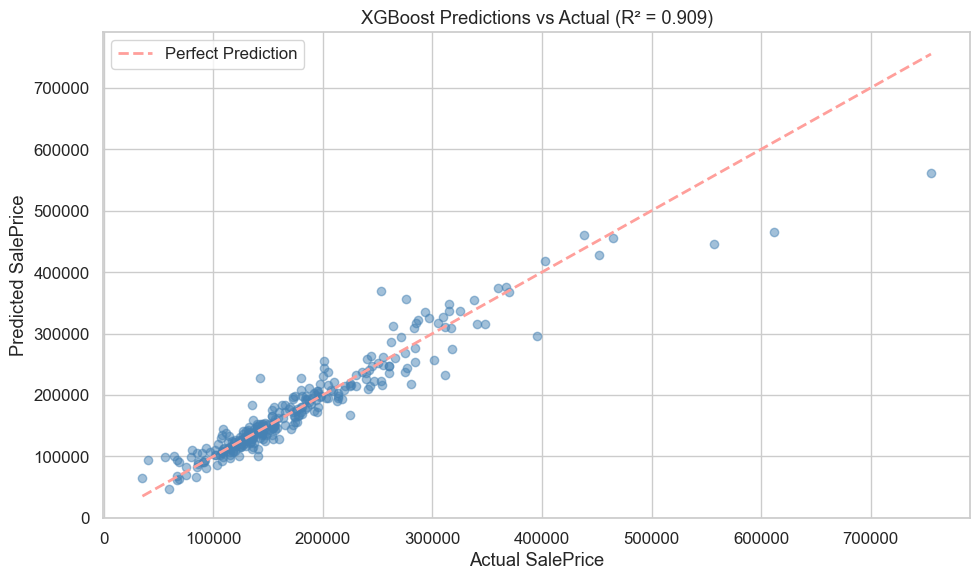

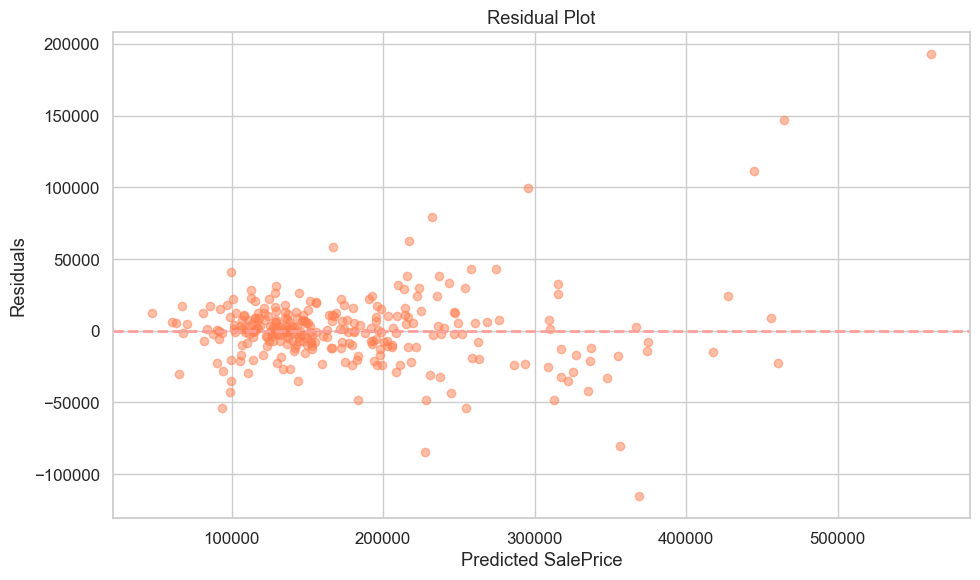

In [15]:
# Create predictions vs actual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.5, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title(f'XGBoost Predictions vs Actual (R² = {r2_final:.3f})')
plt.legend()
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_test - y_pred_final
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuals, alpha=0.5, color='coral')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

C:\Users\keato\AppData\Local\Temp\ipykernel_20240\3916029620.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='viridis')


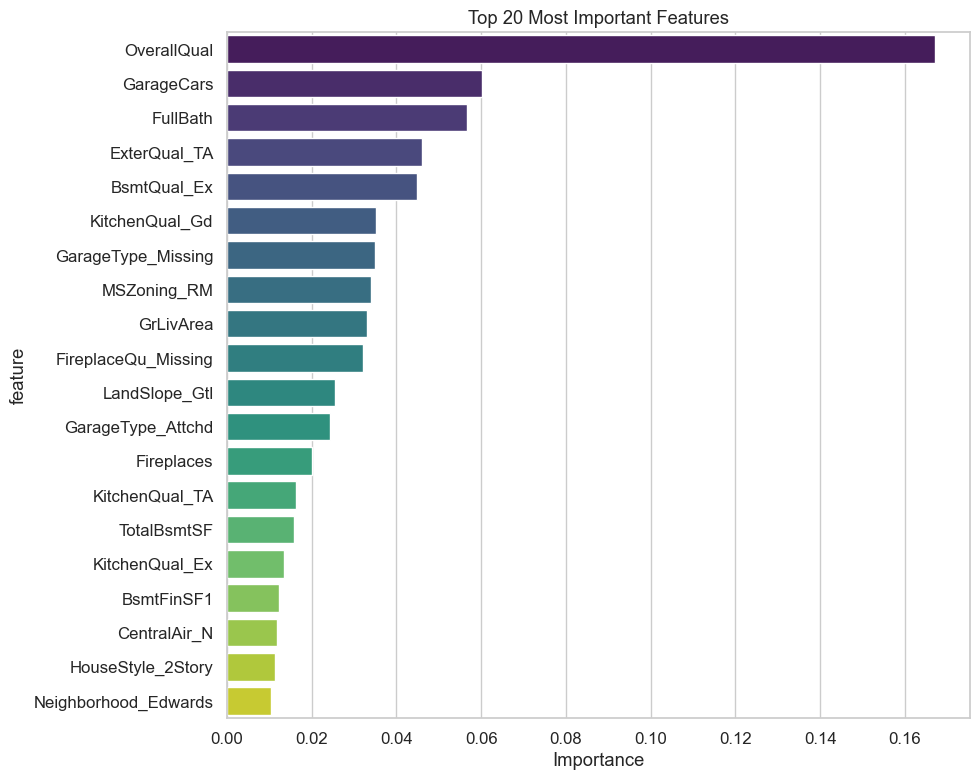

In [16]:
# Get feature importance from the trained model
feature_names = (
    list(numeric_features) + 
    list(final_pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(cat_features))
)

importances = final_pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(20)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [17]:
#Step 5: Make Predictions on New Data (if you have test.csv)
# Load test data
test_data = pd.read_csv('test.csv')
test_ids = test_data['Id']

# Prepare test data (same preprocessing as training)
X_test_new = test_data.drop(['Id'], axis=1)

# Fill missing values
X_test_new[numeric_features] = X_test_new[numeric_features].fillna(
    X_test_new[numeric_features].median()
)
X_test_new[cat_features] = X_test_new[cat_features].fillna('Missing')

# Make predictions
predictions = final_pipeline.predict(X_test_new)

# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
